<a href="https://colab.research.google.com/github/bahti21/transcriptomika/blob/main/hometask2_(new).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Второе дз: до этого я его не делал когда скидывал дз на проверку.

# **ДЗ 2:**  
At home, perform the same analysis with the standard DESeq2 pipeline. DESeq2 documentation is very detailed: https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html. For each step, comment, how it relates to what we did in edgeR.

You can then compare lists of differentially expressed genes between edgeR and DESeq2 using Venn diagrams or plot the p-values of different genes in edgeR and DESeq2 against each other.




План:
1. Составляем матрицу каунтов.
2. PCA разложение.
3. Составлю табличку meta_data.
4. Создам датасет DESeq на основе матрицы каунтов и метаинформации.
5. диаграмма Эйлера-Венна.

In [2]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz
!gunzip GSE110021_counts.Aug2015.txt.gz

--2024-07-14 11:53:31--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE110nnn/GSE110021/suppl/GSE110021%5Fcounts.Aug2015.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067815 (1.0M) [application/x-gzip]
Saving to: ‘GSE110021_counts.Aug2015.txt.gz’

GSE110021_counts.Au 100%[===================>]   1.02M  1.62MB/s    in 0.6s    

2024-07-14 11:53:32 (1.62 MB/s) - ‘GSE110021_counts.Aug2015.txt.gz’ saved [1067815/1067815]



In [3]:
!echo "deb http://security.ubuntu.com/ubuntu focal-security main" | sudo tee /etc/apt/sources.list.d/focal-security.list
!apt-get update
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libssl1.1

!pip install --upgrade gdown
!gdown 1XAbJa_suP-WFTKK628oM9EWsV7k-6fI9
!gdown 1Bt4HDrZqFId_7Ph99pSvhfFHxyrV-kaL
!tar xf library.tar.gz

deb http://security.ubuntu.com/ubuntu focal-security main
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,263 kB]
Ign:12 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/

In [4]:
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")
!Rscript -e 'install.packages("statmod")'
!Rscript -e 'install.packages("VennDiagram")'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/statmod_1.5.0.tar.gz'
Content type 'application/x-gzip' length 92486 bytes (90 KB)
downloaded 90 KB

* installing *source* package ‘statmod’ ...
** package ‘statmod’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using Fortran compiler: ‘GNU Fortran (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-avGvPq/r-base-4.4.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c expectedDeviance.c -o expectedDeviance.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-avGvPq/r-base-4.4.1=. -fstack-protector-strong  -c gaussq2.f -o gaussq2.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-avGvPq/r-base-4.4.

In [9]:
%%R

suppressPackageStartupMessages({
  library(ggplot2)
  library(ggrepel)
  library(stringr)
  library(dplyr)
  library(edgeR)
})

In [10]:
%%R
suppressPackageStartupMessages(library(DESeq2))

In [11]:
%%R

#матрица каунтов

count_matrix <- read.table("GSE110021_counts.Aug2015.txt")
count_matrix <- data.frame(D1_cont_1=rowSums(select(count_matrix, starts_with("D1.noTGFb.1"))),
                            D1_cont_2=rowSums(select(count_matrix, starts_with("D1.noTGFb.2"))),
                            D1_cont_3=rowSums(select(count_matrix, starts_with("D1.noTGFb.3"))),
                            D1_tgf_1=rowSums(select(count_matrix, starts_with("D1.TGFb.1"))),
                            D1_tgf_2=rowSums(select(count_matrix, starts_with("D1.TGFb.2"))),
                            D1_tgf_3=rowSums(select(count_matrix, starts_with("D1.TGFb.3"))),
                            D20_cont_1=rowSums(select(count_matrix, starts_with("D20.noTGFb.1"))),
                            D20_cont_2=rowSums(select(count_matrix, starts_with("D20.noTGFb.2"))),
                            D20_cont_3=rowSums(select(count_matrix, starts_with("D20.noTGFb.3"))),
                            D20_tgf_1=rowSums(select(count_matrix, starts_with("D20.TGFb.1"))),
                            D20_tgf_2=rowSums(select(count_matrix, starts_with("D20.TGFb.2"))),
                            D20_tgf_3=rowSums(select(count_matrix, starts_with("D20.TGFb.3"))))

In [12]:
%%R

#скачиваем информацию о белках

gene_anno <- read.table("biomart_hg19_ensembl75.tsv", sep = '\t', header = TRUE)

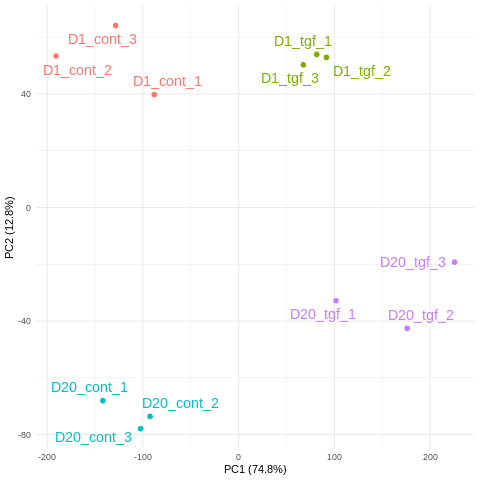

In [13]:
%%R

#разложение PCA
# scale the data
counts_scaled <- t(scale(count_matrix))

# run PCA
pca_result <- prcomp(counts_scaled, center = TRUE, scale. = TRUE)
variance_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2) * 100

# extract first two PCs
scores_df <- data.frame(PC1 = pca_result$x[,1], PC2 = pca_result$x[,2])
scores_df$Sample = row.names(scores_df)
groups <- str_remove(scores_df$Sample, "_[0-9]+$")
scores_df$group = groups

# plot first two PCs
ggplot(scores_df, aes(x = PC1, y = PC2, label = Sample, color = group)) +
  geom_point(size=2) +
  geom_text_repel(size=5,
                  box.padding = 0.5,
                  point.padding = 0.5,
                  max.overlaps = Inf)+
  theme_minimal()+
  theme(legend.position = "none")+
  labs(x=paste("PC1 (", sprintf("%.1f", variance_explained[1]), "%)", sep=""),,
       y=paste("PC2 (", sprintf("%.1f", variance_explained[2]), "%)", sep=""),)

In [14]:
%%R

#строим таблицу meta data

meta_data <- data.frame(colnames(count_matrix), groups)

In [15]:
#создадим датасет DEseq2 на основе матрицы каунтов и метаинформации
%%R

dataset <- DESeqDataSetFromMatrix(countData = count_matrix,           #данные
                                  colData = meta_data,                #свойства колонки
                                  design= ~ groups                    #здесь столбец из meta_data, по которому будем группировать при анализе
                                  )

In [16]:
%%R

dataset

class: DESeqDataSet 
dim: 25702 12 
metadata(1): version
assays(1): counts
rownames(25702): 653635 100422834 ... 114760 100506511
rowData names(0):
colnames(12): D1_cont_1 D1_cont_2 ... D20_tgf_2 D20_tgf_3
colData names(2): colnames.count_matrix. groups


In [17]:
%%R
#фильтрация редких белков, может, тут ее и не нужно делать
smallestGroupSize <- 3
keep <- rowSums(counts(dataset) >= 10) >= smallestGroupSize
dataset <- dataset[keep,]

In [18]:
%%R
#запускаем DESeq2 анализ!
dataset2 <- DESeq(dataset)

In [19]:
%%R
#результаты получаем для разных групп, нужные группы указаны вот тут внизу
result_D1_cont_VS_tgf <- results(dataset2, contrast=c("groups","D1_cont","D1_tgf"))
result_D20_cont_VS_tgf <- results(dataset2, contrast=c("groups", "D20_cont", "D20_tgf"))
result_Cont_D1_VS_D20 <- results(dataset2, contrast=c("groups", "D1_cont", "D20_cont"))
result_TGF_D1_VS_D20 <- results(dataset2, contrast=c("groups", "D1_tgf", "D20_tgf"))

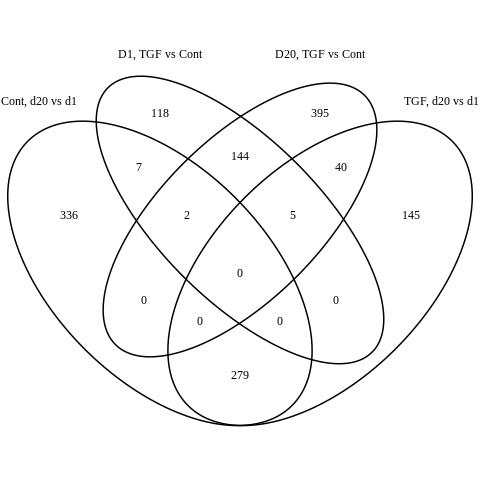

In [22]:
%%R
#строим диаграмму эйлера венна аналогично тому, как мы это делали на семинаре
de_genes_cont_20vs1 <- row.names(subset(result_Cont_D1_VS_D20, padj < 0.05 & log2FoldChange > 1))
de_genes_tgf_20vs1 <- row.names(subset(result_TGF_D1_VS_D20, padj < 0.05 & log2FoldChange > 1))
de_genes_d1_tgf <- row.names(subset(result_D1_cont_VS_tgf, padj < 0.05 & log2FoldChange > 1))
de_genes_d20_tgf <- row.names(subset(result_D20_cont_VS_tgf, padj < 0.05 & log2FoldChange > 1))

# Use VennDiagram package to plot the Venn diagram
library(VennDiagram)
venn.plot <- venn.diagram(
  x = list(
    Cont_20vs1 = de_genes_cont_20vs1,
    TGF_20vs1 = de_genes_tgf_20vs1,
    D1_TGF = de_genes_d1_tgf,
    D20_TGF = de_genes_d20_tgf
  ),
  category.names = c("Cont, d20 vs d1", "TGF, d20 vs d1", "D1, TGF vs Cont", "D20, TGF vs Cont"),
  filename = NULL
)
grid.draw(venn.plot)

In [21]:
%%R

result_TGF_D1_VS_D20

log2 fold change (MLE): groups D1_tgf vs D20_tgf 
Wald test p-value: groups D1_tgf vs D20_tgf 
DataFrame with 14049 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat      pvalue        padj
          <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
653635     47.17915     -0.1688958  0.255685 -0.660561   0.5088939    0.635925
100131754  12.59066      0.8406284  0.503384  1.669956   0.0949281    0.176336
100133331  17.50954     -0.7490400  0.421578 -1.776755   0.0756085    0.147122
79854       8.69013     -0.5654981  0.645194 -0.876477   0.3807706    0.516183
643837     48.23897     -0.0488766  0.262441 -0.186238   0.8522582    0.904546
...             ...            ...       ...       ...         ...         ...
7411      878.69331      0.4377133  0.103328  4.236146 2.27389e-05 1.35459e-04
116442     17.99814     -3.8888975  0.574801 -6.765642 1.32719e-11 2.76604e-10
1193       35.57454     -1.5423214  0.331599 -4.651163 3.30069e-06 2.38257e